In [1]:
import os 
# from utils.utils import *

# from fog.code.utils.utils import *
from pyspark.sql.functions import lit, col
from pyspark.sql.types import StringType, BooleanType, IntegerType, FloatType, DateType
from pyspark.sql import SparkSession
from google.cloud import storage

import matplotlib.pyplot as plt
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
    # measures how close each point in one cluster is to points in the neighboring clusters 
    #  helping in figuring out clusters that are compact and well-spaced out.

In [2]:
spark = SparkSession.builder.appName("K-Means Test").getOrCreate()

## Read in daily processed parquet files

In [3]:
daily_path = "parkinsons_data/unlabeled_combined/daily_one_day"
top_bucket_name = "msca-bdp-student-gcs"
bucket_path = "gs://msca-bdp-student-gcs/parkinsons_data/unlabeled_combined/daily_one_day"
print(top_bucket_name)

msca-bdp-student-gcs


In [4]:
client = storage.Client()
blobs = client.list_blobs(top_bucket_name, prefix=daily_path)

daily_processed = None

for i, blob in enumerate(blobs):
    print(blob.name)
    if blob.name.endswith('.parquet'):
        # print(i)
        df = spark.read.parquet(f"gs://{top_bucket_name}/{blob.name}")
        if daily_processed is None:
            daily_processed = df
        else:
            daily_processed = daily_processed.union(df)

parkinsons_data/unlabeled_combined/daily_one_day/
parkinsons_data/unlabeled_combined/daily_one_day/_SUCCESS
parkinsons_data/unlabeled_combined/daily_one_day/part-00000-8e482b6f-68bc-40e8-afaa-fcc6b8f880ea-c000.snappy.parquet


parkinsons_data/unlabeled_combined/daily_one_day/part-00014-8e482b6f-68bc-40e8-afaa-fcc6b8f880ea-c000.snappy.parquet
parkinsons_data/unlabeled_combined/daily_one_day/part-00044-8e482b6f-68bc-40e8-afaa-fcc6b8f880ea-c000.snappy.parquet


parkinsons_data/unlabeled_combined/daily_one_day/part-00074-8e482b6f-68bc-40e8-afaa-fcc6b8f880ea-c000.snappy.parquet
parkinsons_data/unlabeled_combined/daily_one_day/part-00104-8e482b6f-68bc-40e8-afaa-fcc6b8f880ea-c000.snappy.parquet
parkinsons_data/unlabeled_combined/daily_one_day/part-00134-8e482b6f-68bc-40e8-afaa-fcc6b8f880ea-c000.snappy.parquet
parkinsons_data/unlabeled_combined/daily_one_day/part-00164-8e482b6f-68bc-40e8-afaa-fcc6b8f880ea-c000.snappy.parquet
parkinsons_data/unlabeled_combined/daily_one_day/part-00194-8e482b6f-68bc-40e8-afaa-fcc6b8f880ea-c000.snappy.parquet
parkinsons_data/unlabeled_combined/daily_one_day/part-00224-8e482b6f-68bc-40e8-afaa-fcc6b8f880ea-c000.snappy.parquet
parkinsons_data/unlabeled_combined/daily_one_day/part-00254-8e482b6f-68bc-40e8-afaa-fcc6b8f880ea-c000.snappy.parquet
parkinsons_data/unlabeled_combined/daily_one_day/part-00284-8e482b6f-68bc-40e8-afaa-fcc6b8f880ea-c000.snappy.parquet
parkinsons_data/unlabeled_combined/daily_one_day/part-00314-8e48

In [5]:
daily_processed.show(1)

+-------+----------+----+--------+---------+--------+-----+------------+-----+-----------+
|Subject|        Id|Time|    AccV|    AccML|   AccAP|Visit|record_begin|NFOGQ|TimeSeconds|
+-------+----------+----+--------+---------+--------+-----+------------+-----+-----------+
| 3d8b73|00c4c9313d|   0|0.328125|-0.109375|0.671875|    1|       10:19|    0|        0.0|
+-------+----------+----+--------+---------+--------+-----+------------+-----+-----------+
only showing top 1 row



In [6]:
daily_processed.count()

83040

In [7]:
daily_processed.printSchema()

root
 |-- Subject: string (nullable = true)
 |-- Id: string (nullable = true)
 |-- Time: long (nullable = true)
 |-- AccV: float (nullable = true)
 |-- AccML: float (nullable = true)
 |-- AccAP: float (nullable = true)
 |-- Visit: string (nullable = true)
 |-- record_begin: string (nullable = true)
 |-- NFOGQ: string (nullable = true)
 |-- TimeSeconds: double (nullable = true)



### Convert attributes into features
(Not currently including subject, Id, visit, record_begin, or NFOGQ in the features, but not sure if that's the correct decision)

Also chose to use timeSeconds, not Time, but not sure if that would make any difference...didn't use both because that seemed redundant


In [8]:
# Need to go back to make visit an integer?? 
# Not including as string in vectorizer

In [9]:
daily_processed.columns

['Subject',
 'Id',
 'Time',
 'AccV',
 'AccML',
 'AccAP',
 'Visit',
 'record_begin',
 'NFOGQ',
 'TimeSeconds']

In [10]:
assemble=VectorAssembler(inputCols=[
    'AccV', 'AccML', 'AccAP', 'TimeSeconds'], outputCol = 'features')

assembled_data = assemble.transform(daily_processed)
assembled_data.show(2)


+-------+----------+----+----------+------------+----------+-----+------------+-----+-----------+--------------------+
|Subject|        Id|Time|      AccV|       AccML|     AccAP|Visit|record_begin|NFOGQ|TimeSeconds|            features|
+-------+----------+----+----------+------------+----------+-----+------------+-----+-----------+--------------------+
| 3d8b73|00c4c9313d|   0|  0.328125|   -0.109375|  0.671875|    1|       10:19|    0|        0.0|[0.328125,-0.1093...|
| 3d8b73|00c4c9313d|   1|0.45310798|-0.124720864|0.81127316|    1|       10:19|    0|       0.01|[0.45310798287391...|
+-------+----------+----+----------+------------+----------+-----+------------+-----+-----------+--------------------+
only showing top 2 rows



### Standardize the data
https://towardsdatascience.com/k-means-clustering-using-pyspark-on-big-data-6214beacdc8b

In [11]:
scale = StandardScaler(inputCol='features', outputCol = 'standardized')
data_scale = scale.fit(assembled_data)
data_scale_output = data_scale.transform(assembled_data)
data_scale_output.show(2)

+-------+----------+----+----------+------------+----------+-----+------------+-----+-----------+--------------------+--------------------+
|Subject|        Id|Time|      AccV|       AccML|     AccAP|Visit|record_begin|NFOGQ|TimeSeconds|            features|        standardized|
+-------+----------+----+----------+------------+----------+-----+------------+-----+-----------+--------------------+--------------------+
| 3d8b73|00c4c9313d|   0|  0.328125|   -0.109375|  0.671875|    1|       10:19|    0|        0.0|[0.328125,-0.1093...|[0.72291917292216...|
| 3d8b73|00c4c9313d|   1|0.45310798|-0.124720864|0.81127316|    1|       10:19|    0|       0.01|[0.45310798287391...|[0.99827946125299...|
+-------+----------+----+----------+------------+----------+-----+------------+-----+-----------+--------------------+--------------------+
only showing top 2 rows



### Use the Silhouette Score to determine ideal number of clusters
https://www.data4v.com/tutorial-k-means-clustering-on-spark/

In [12]:
silhouette_score = []
evaluator = ClusteringEvaluator(predictionCol = 'prediction', \
                                featuresCol = 'standardized', \
                                metricName = 'silhouette', \
                                distanceMeasure = 'squaredEuclidean')

for i in range(2,11):
    kmeans = KMeans(featuresCol = 'standardized', k = i)
    kmeans_fit = kmeans.fit(data_scale_output)
    output = kmeans_fit.transform(data_scale_output)
    
    evaluation_score = evaluator.evaluate(output)
    silhouette_score.append(evaluation_score)

print(f"Scores:", silhouette_score)
    

23/05/17 22:48:21 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
23/05/17 22:48:21 WARN com.github.fommil.netlib.BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


Scores: [0.31633787131780317, 0.362085810017561, 0.39889902648584, 0.4651390921697337, 0.46600087854135563, 0.5015823829611181, 0.5083104144249604, 0.5199848826443698, 0.5205597276581154]


Text(0, 0.5, 'Silhouette Score')

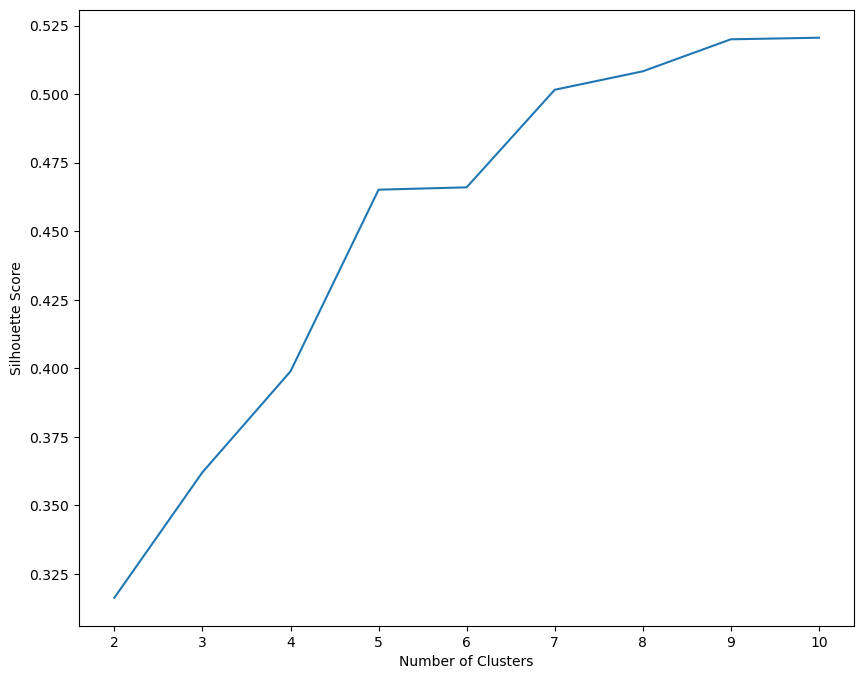

In [13]:
fig, ax = plt.subplots(1,1, figsize = (10,8))
ax.plot(range(2,11), silhouette_score)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

### Run model with k clusters
https://www.educba.com/pyspark-kmeans/

In [14]:
groups = 5
kmeans = KMeans(featuresCol = 'standardized', k = groups, seed = 1)
model = kmeans.fit(data_scale_output.select('standardized'))
transformed = model.transform(data_scale_output)


In [15]:
transformed.select("Subject", "Id", "Time", "standardized", "prediction").show(5)

+-------+----------+----+--------------------+----------+
|Subject|        Id|Time|        standardized|prediction|
+-------+----------+----+--------------------+----------+
| 3d8b73|00c4c9313d|   0|[0.72291917292216...|         2|
| 3d8b73|00c4c9313d|   1|[0.99827946125299...|         2|
| 3d8b73|00c4c9313d|   2|[0.93203947384370...|         2|
| 3d8b73|00c4c9313d|   3|[0.33050978533900...|         2|
| 3d8b73|00c4c9313d|   4|[-0.4450496240401...|         2|
+-------+----------+----+--------------------+----------+
only showing top 5 rows



In [16]:
transformed.select("prediction").distinct().show()
transformed.groupBy("prediction").count().show()

+----------+
|prediction|
+----------+
|         1|
|         3|
|         4|
|         2|
|         0|
+----------+



+----------+-----+
|prediction|count|
+----------+-----+
|         1|17168|
|         3| 9158|
|         4|11981|
|         2|22735|
|         0|21998|
+----------+-----+



### Visualize Clustering Using PCA
https://www.data4v.com/tutorial-k-means-clustering-on-spark/

In [17]:
from pyspark.ml.feature import PCA as PCAml
pca = PCAml(k = 2, inputCol = 'standardized', outputCol = 'pca')
pca_model = pca.fit(data_scale_output)
pca_transformed = pca_model.transform(data_scale_output)

23/05/17 22:51:26 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
23/05/17 22:51:26 WARN com.github.fommil.netlib.LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [18]:
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

In [19]:
cluster_assignment = np.array(transformed.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

pca_data = np.hstack((x_pca,cluster_assignment))

pca_df = pd.DataFrame(data=pca_data, columns=("1st_principal", "2nd_principal","cluster_assignment"))
sns.FacetGrid(pca_df,hue="cluster_assignment", height=6).map(plt.scatter, '1st_principal', '2nd_principal' ).add_legend()

plt.show()